In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

# IMPORT THE DATASET

In [72]:
data = pd.read_csv(r"C:\Users\Ekin\Desktop\PM datasets\tweets.csv")
data.head()

,source_created_at,author_id,text,source,language,longitude,latitude,id,source_id,tweet_id,user_id,relevant,topic,ground_truth,sentiment
0,2020-09-18 21:56:20.798000,593731316,@DSisourath The Thameslink core between London...,sprinklr,en,-0.12574,51.50853,acd7673f-e621-5f1a-d662-df278964a6ea,NaN,acd7673f-e621-5f1a-d662-df278964a6ea,Z003XDCS,True,service,True,negative
1,2020-10-13 07:31:53.122000,745583289520496640,@DulwichHistory Loving the complaint about peo...,sprinklr,en,-0.12574,51.50853,5b92aba8-4b05-6c63-8485-e9c870742137,NaN,5b92aba8-4b05-6c63-8485-e9c870742137,Z003XDCS,True,delays,True,negative
2,2020-10-26 19:27:24.695000,303134761,@SW_Help .And yet you have no toilets on some ...,sprinklr,en,-0.12574,51.50853,0a799c07-8b76-17ba-b840-e538d51e832d,NaN,0a799c07-8b76-17ba-b840-e538d51e832d,Z003XDCS,True,toilets,True,negative
3,2020-10-26 19:28:49.281000,303134761,@SW_Help you have no toilets on some of your t...,sprinklr,en,-0.12574,51.50853,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,NaN,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,Z003XDCS,True,toilets,True,negative
4,2020-09-28 11:59:41.212000,56427671,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,sprinklr,en,-1.09125,50.79899,1fd08862-d8c7-0682-6b11-2603fba22d94,NaN,1fd08862-d8c7-0682-6b11-2603fba22d94,Z003XDCS,True,seats,True,neutral


# REMOVE UNNECESSARY COLUMNS EXCEPT 'TEXT' & 'SENTIMENT'

In [73]:
# drop other columns except Tweet Content and Sentiment

data.drop(data.columns.difference(['text','sentiment']), axis=1, inplace=True)
data

,text,sentiment
0,@DSisourath The Thameslink core between London...,negative
1,@DulwichHistory Loving the complaint about peo...,negative
2,@SW_Help .And yet you have no toilets on some ...,negative
3,@SW_Help you have no toilets on some of your t...,negative
4,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,neutral
...,...,...
16944,Haha oh man the audio corruption on @TLRailUK ...,neutral
16945,@TLRailUK SweetIs there a plug to charge my ph...,neutral
16946,@TLRailUK now there are far fewer commuters ha...,neutral
16947,@geofftech I am voting for Thameslink. 1. in a...,neutral


# SPLIT DATA INTO TRAINING, TEST & VALIDATION SETS

In [74]:
# Split the dataset into training, test & validation sets with ratio 70-15-15
# First, split dataset into traing & test (ratio 85-15) then split training sets into training & validation (70-15)
# Target variable is sentiment
# Return: X_train, X_test, X_val, y_train, y_test, y_val
# Parameters:
#    random_state: make sure to get the same 3 subsets everytime. Set to be any int values
#    stratify = sentiment (since there was an imbalance in neg, neu and positive sentiments and we have to set this in order to keep the same ratio in our subsets)

X = data.drop(columns='sentiment') #the entire dataframe without sentiment column
y = data['sentiment'] # our target variable

X_main, X_test, y_main, y_test = train_test_split(X,y,test_size = 0.15, random_state=2, stratify = y) #split datasset into main & test set
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.15, random_state=2, stratify = y_main) #split main into train & validation sets

In [75]:
print("Length of training set:\t\t",len(X_train)," ",len(y_train))
print("Length of test set:\t\t",len(X_test)," ",len(y_test))
print("Length of validation set:\t",len(X_val)," ",len(y_val))

Length of training set:		 12245   12245
Length of test set:		 2543   2543
Length of validation set:	 2161   2161


# CREATE SENTIMENT DATASET

In [76]:
# create sentiment dataset

sentiment_data = pd.DataFrame(X_train)
sentiment_data['sentiment'] = y_train
sentiment_data.sort_values(by='text', inplace=True)

# REMOVE DUPLICATE ROWS (I.E. SAME TEXT & SAME SENTIMENT)

In [77]:
# Show total number of duplicate rows
# Keep 1 of the duplicates in the dataframe, anything else is flagged as duplicates 
# Some have 2 duplicates and some has 3 duplicates   

print('Total duplicate rows (same text, same sentiment): ', sentiment_data.duplicated().sum())

Total duplicate rows (same text, same sentiment):  640


In [78]:
# list all duplicate rows in the entire dataset
# duplicated() parameters:
#    By default, keep = 'first': 1st of duplicated rows to be kept in the dataframe, the rest to be flagged as duplicates and show down here
#    keep = 'last': last of duplicated rows to be kept in the dataframe, the rest to be flagged as duplicates and show down here
#    keep = False: flag and show all duplicated rows (not keeping any rows in dataframe)

sentiment_data.loc[sentiment_data.duplicated(keep = False),:]

,text,sentiment
67,#EastCroydon #LondonBridge #Victoria use https...,negative
66,#EastCroydon #LondonBridge #Victoria use https...,negative
283,#TLUpdates - Following a road vehicle collidin...,negative
284,#TLUpdates - Following a road vehicle collidin...,negative
357,#TLUpdates - Please allow extra time for your ...,negative
...,...,...
14476,⁦@TLRailUK⁩ why no tray tables? Coffee running...,negative
14516,⚠️ #SNUpdates - Train services running through...,negative
14517,⚠️ #SNUpdates - Train services running through...,negative
15072,"📣 #NewInstruction!🏡 #ForSale: Millway, #NW7A w...",neutral


In [79]:
# Drop rows that already flagged as duplicates (keep 1 row in the dataframe)
# inplace=True: make changes to the origial DataFrame

sentiment_data.drop_duplicates(inplace=True)

In [80]:
sentiment_data.duplicated().sum()

0

# LIST DUPLICATE TWEET WITH DIFFERENT SENTIMENT

In [81]:
# how many duplicate Tweets with different sentiment remain in the dataset

print('Total duplicate Tweet with different sentiment: ',sentiment_data['text'].duplicated().sum())

Total duplicate Tweet with different sentiment:  17


In [82]:
# show first 20 rows that has duplicate Tweets with different sentiment
# by default, only show the 1st row of duplicate and drop the last row of duplicate
# if want to keep the last row instead, set the parameter to duplicate(keep = 'last')
# if want to show both the duplicates, set the parameter to duplicate(False)

sentiment_data[sentiment_data['text'].duplicated(keep=False)].head(20)

,text,sentiment
2614,@AndyBraben @TLRailUK @CoyModemKnight @Cameron...,neutral
15247,@AndyBraben @TLRailUK @CoyModemKnight @Cameron...,negative
15260,"@BugsieGiven @GNRailUK Mind you, given the cho...",neutral
2741,"@BugsieGiven @GNRailUK Mind you, given the cho...",negative
15266,@CentralBeds @TLRailUK Lucky they got a seat i...,negative
2779,@CentralBeds @TLRailUK Lucky they got a seat i...,neutral
15327,@JDrvr @TLRailUK Those announcements always me...,neutral
3285,@JDrvr @TLRailUK Those announcements always me...,negative
3432,@LambrettaGT205 @TLRailUK @Haleypest No tables...,negative
15346,@LambrettaGT205 @TLRailUK @Haleypest No tables...,neutral


In [83]:
# The duplicate Tweets with different sentiment is because they have different topics.
# However, knowing they belong to different topics doesn't help with our model building because some of them are just sarcasm, wrong classification 
# Hence, it's best to remove these 17 Tweets from our dataset

# Remove duplicate Tweet with different sentiment
sentiment_data.drop_duplicates(['text'], inplace=True)

In [84]:
sentiment_data['text'].duplicated().sum()

0

In [85]:
print('Dataset for sentiment is ',sentiment_data.shape)

Dataset for sentiment is  (11588, 2)


# CHECK MISSING VALUES IN THE DATASET

In [86]:
sentiment_data.isnull().any()

text         False
sentiment    False
dtype: bool

# CLEANING TWEET CONTENT

In [87]:
# load spacy English language model trained based on web and social media texts
# add more stop words to the list of stop words list in spacy

nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'thameslink','tlupdates','gtrailuk','tlrailuk','govia', 'gtr'}

In [88]:
STOP_WORDS

print(len(STOP_WORDS))
print(STOP_WORDS)

332
{'alone', 'hereby', 'did', 'might', 'often', 'itself', 'always', 'everyone', 'due', 'gtrailuk', 'my', 'become', 'mine', 'his', 'anyway', 'only', 'him', 'more', 'throughout', 'since', 'a', 'whoever', 'how', 'latterly', 'latter', '‘m', 'should', 'anyone', 'therefore', 'thus', 'namely', 'through', 'within', 'seemed', "'m", 'much', 'really', 'top', 'does', 'twenty', 'those', 'against', 'least', "'ve", 'anyhow', 'using', 'sometime', 'none', 'thereupon', '’d', 'hereafter', 'ten', 'besides', 'eight', 'am', 'whenever', 'every', 'ca', 'may', 'twelve', 'your', 'all', 'done', 'either', 'formerly', 'there', 'between', 'give', 'must', 'forty', 'it', 'per', '’ve', 'tlrailuk', 'had', 'are', 'noone', 'whether', 'next', 'amongst', 'which', 'each', 'has', 'few', 'everywhere', 'her', 'ever', 'still', 'off', '‘d', 'other', 'hers', 'seem', 'if', 'cannot', 'seems', 'hence', "'re", 'front', 'even', 'everything', 'hundred', 'already', 'put', 'afterwards', 'fifty', 'go', 'ours', 'by', 'nowhere', 'just', 't

In [89]:
# Create a function to clean tweet content
# Tweet will be cleaned by the following steps:
# 1. Remove emoji
# 2. Remove #TLUpdates
# 3. Turn word to lowercase
# 4. Remove Twitter @usernames
# 5. Remove hyperlink
# 6. Remove punctuations
# Use function re.sub() to subsitute particular sub-string with another sub-string 
    # arguments: (condition [or pattern], substitute with, passing string).
    # Patterns: 
    # [ character block start
    # ^ not these characters (letters, numbers)
    # \w word characters
    # \s space characters
    # ] character block end.

def cleanText(text):
    #create a list of emojis pattern
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags = re.UNICODE)
    text = re.sub(emoji_pattern,'', text) #remove emoji    
    text = re.sub(r'#TLUpdates','',text) #remove the hashtag #TLUpdates    
    text = text.lower() #turn every capitalization to lowercase    
    text = re.sub(r'@[A-Za-z0-9\_]+','',text) #remove @usernames, format of a username: alphanumeric characters (letters A-Z, numbers 0-9) with the exception of underscores
    text = re.sub(r'https?:\/\/\S+','',text) #remove hyperlink
    text = re.sub(r'\b\d+\b','',text) #remove numbers
    #text = re.sub(r'[^\w\s]','',text) #remove punctuations
    return text

In [90]:
# Clean the tweet content
# Use for loop to run through every tweets in the clean dataset
# Cleaning steps include:
# 1. Basic clean (i.e. remove unnecessary emojis, patterns, punctuation...) using the cleanText function above
# 2. Tokenization: break sentence into words
# 3. Remove stop words
# 4. Lemmatization: strip words down to its root/stem

def cleanData(main_df):
    df = main_df.copy()
    lemmatizer = WordNetLemmatizer()

    for index, row in df.iterrows():
        filter_sentence = []
        sentence = cleanText(row['text']) # call our function above to clean user text
        words = nltk.word_tokenize(sentence) # tokenization
        words = [w for w in words if not w in STOP_WORDS] # stopwords removal
        for word in words:
            filter_sentence.append(lemmatizer.lemmatize(word)) # lemmatization
        df.at[index,'text'] = filter_sentence  
    return df

# SENTIMENT ANALYSIS WITH TEXTBLOB

In [91]:
TextBlob_df = sentiment_data.copy()

In [92]:
# Clean the tweet content

TextBlob_df['text'] = TextBlob_df['text'].apply(cleanText)
TextBlob_df

,text,sentiment
15196,""" govia thameslink fined £1m over passenger ki...",neutral
25,"""congestion"" is not a reason for delay, it's a...",negative
26,"""govia thameslink railway (gtr) is facing a £5...",negative
28,"""my apologies passengers, we appear to be havi...",negative
29,"""no more trains passing through platform . ple...",negative
...,...,...
15074,to the woman at west hampstead thameslink who...,neutral
15076,the new thameslink trains use regenerative br...,neutral
15077,•overground: minor delays hackney wick to str...,neutral
15078,a fault on a train earlier today at city tham...,negative


In [93]:
# Create a function to get the subjectivity
# tell the user if the given sentence is subjective or objective
# Return values in range [0,1]
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [94]:
# Create a function to get the polarity
# tell the user if the given sentence is negative, neutral or positive
# Return values in range [-1,1]
# -1: negative
# 0: neutral
# 1: positive
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [95]:
# Create 2 new columns Subjectivity and Polarity
TextBlob_df['Subjectivity'] = TextBlob_df['text'].apply(getSubjectivity)
TextBlob_df['Polarity'] = TextBlob_df['text'].apply(getPolarity)

In [96]:
# Show the new dataframe with newly-added columns Subjectivity and Polarity
TextBlob_df

,text,sentiment,Subjectivity,Polarity
15196,""" govia thameslink fined £1m over passenger ki...",neutral,0.000000,-0.200000
25,"""congestion"" is not a reason for delay, it's a...",negative,0.651515,0.545455
26,"""govia thameslink railway (gtr) is facing a £5...",negative,0.340404,0.184343
28,"""my apologies passengers, we appear to be havi...",negative,0.000000,0.000000
29,"""no more trains passing through platform . ple...",negative,0.260000,0.090000
...,...,...,...,...
15074,to the woman at west hampstead thameslink who...,neutral,0.000000,0.000000
15076,the new thameslink trains use regenerative br...,neutral,0.361818,0.094545
15077,•overground: minor delays hackney wick to str...,neutral,0.100000,-0.025000
15078,a fault on a train earlier today at city tham...,negative,0.250000,0.000000


In [97]:
# Create a function to compute the negative, neutral and positive analysis
def SentimentAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [98]:
# Create 1 new column SentimentAnalysis
TextBlob_df['TextBlob Analysis'] = TextBlob_df['Polarity'].apply(SentimentAnalysis)
TextBlob_df

,text,sentiment,Subjectivity,Polarity,TextBlob Analysis
15196,""" govia thameslink fined £1m over passenger ki...",neutral,0.000000,-0.200000,Negative
25,"""congestion"" is not a reason for delay, it's a...",negative,0.651515,0.545455,Positive
26,"""govia thameslink railway (gtr) is facing a £5...",negative,0.340404,0.184343,Positive
28,"""my apologies passengers, we appear to be havi...",negative,0.000000,0.000000,Neutral
29,"""no more trains passing through platform . ple...",negative,0.260000,0.090000,Positive
...,...,...,...,...,...
15074,to the woman at west hampstead thameslink who...,neutral,0.000000,0.000000,Neutral
15076,the new thameslink trains use regenerative br...,neutral,0.361818,0.094545,Positive
15077,•overground: minor delays hackney wick to str...,neutral,0.100000,-0.025000,Negative
15078,a fault on a train earlier today at city tham...,negative,0.250000,0.000000,Neutral


In [99]:
TextBlob_df.groupby(['sentiment','TextBlob Analysis']).size()

sentiment  TextBlob Analysis
negative   Negative             3096
           Neutral              1520
           Positive             2594
neutral    Negative             1358
           Neutral              1014
           Positive             1838
positive   Negative               13
           Neutral                26
           Positive              129
dtype: int64

# SENTIMENT ANALYSIS WITH VADER

In [100]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ekin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [101]:
sentiment_data

,text,sentiment
15196,""" Govia Thameslink fined £1m over passenger ki...",neutral
25,"""Congestion"" is NOT a reason for delay, it's a...",negative
26,"""Govia Thameslink Railway (GTR) is facing a £5...",negative
28,"""My apologies passengers, we appear to be havi...",negative
29,"""No more trains passing through platform 5. Pl...",negative
...,...,...
15074,🙌 to the woman at West Hampstead Thameslink wh...,neutral
15076,🚄 The new Thameslink trains use regenerative b...,neutral
15077,🚄 •Overground: minor delays Hackney Wick to St...,neutral
15078,🚆 A fault on a train earlier today at City Tha...,negative


In [102]:
Vader_df = sentiment_data.copy()

In [103]:
# Clean the tweet content

Vader_df['text'] = Vader_df['text'].apply(cleanText)
Vader_df

,text,sentiment
15196,""" govia thameslink fined £1m over passenger ki...",neutral
25,"""congestion"" is not a reason for delay, it's a...",negative
26,"""govia thameslink railway (gtr) is facing a £5...",negative
28,"""my apologies passengers, we appear to be havi...",negative
29,"""no more trains passing through platform . ple...",negative
...,...,...
15074,to the woman at west hampstead thameslink who...,neutral
15076,the new thameslink trains use regenerative br...,neutral
15077,•overground: minor delays hackney wick to str...,neutral
15078,a fault on a train earlier today at city tham...,negative


In [104]:
# reset the index and create column id

Vader_df = Vader_df.reset_index()
Vader_df.drop('index', axis=1, inplace=True)
Vader_df.insert(0, 'id', Vader_df.index)
Vader_df

,id,text,sentiment
0,0,""" govia thameslink fined £1m over passenger ki...",neutral
1,1,"""congestion"" is not a reason for delay, it's a...",negative
2,2,"""govia thameslink railway (gtr) is facing a £5...",negative
3,3,"""my apologies passengers, we appear to be havi...",negative
4,4,"""no more trains passing through platform . ple...",negative
...,...,...,...
11583,11583,to the woman at west hampstead thameslink who...,neutral
11584,11584,the new thameslink trains use regenerative br...,neutral
11585,11585,•overground: minor delays hackney wick to str...,neutral
11586,11586,a fault on a train earlier today at city tham...,negative


In [105]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analysis = SentimentIntensityAnalyzer()

In [106]:
# Run the polarity score on the entire dataset

from itertools import islice #import to run the for loop for the number of row & col of your choice

result = {}

for index, row in islice(Vader_df.iterrows(), 0, len(Vader_df)):
    text = row['text']
    myid = row['id']
    
    result[myid] = analysis.polarity_scores(text)

In [107]:
#result

In [108]:
pd.DataFrame(result).T

,neg,neu,pos,compound
0,0.290,0.710,0.000,-0.6705
1,0.099,0.722,0.178,0.3870
2,0.101,0.849,0.049,-0.4404
3,0.000,1.000,0.000,0.0000
4,0.096,0.779,0.125,0.3329
...,...,...,...,...
11583,0.000,1.000,0.000,0.0000
11584,0.000,0.896,0.104,0.4939
11585,0.169,0.831,0.000,-0.6249
11586,0.182,0.818,0.000,-0.7269


In [109]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns = {'index': 'id'})
vaders = vaders.merge(Vader_df, how='left')

In [110]:
vaders

,id,neg,neu,pos,compound,text,sentiment
0,0,0.290,0.710,0.000,-0.6705,""" govia thameslink fined £1m over passenger ki...",neutral
1,1,0.099,0.722,0.178,0.3870,"""congestion"" is not a reason for delay, it's a...",negative
2,2,0.101,0.849,0.049,-0.4404,"""govia thameslink railway (gtr) is facing a £5...",negative
3,3,0.000,1.000,0.000,0.0000,"""my apologies passengers, we appear to be havi...",negative
4,4,0.096,0.779,0.125,0.3329,"""no more trains passing through platform . ple...",negative
...,...,...,...,...,...,...,...
11583,11583,0.000,1.000,0.000,0.0000,to the woman at west hampstead thameslink who...,neutral
11584,11584,0.000,0.896,0.104,0.4939,the new thameslink trains use regenerative br...,neutral
11585,11585,0.169,0.831,0.000,-0.6249,•overground: minor delays hackney wick to str...,neutral
11586,11586,0.182,0.818,0.000,-0.7269,a fault on a train earlier today at city tham...,negative


In [111]:
# create a list of conditions
conditions =[
    (vaders['compound'] < 0),
    (vaders['compound'] == 0),
    (vaders['compound'] > 0)
    ]

# create a list of sentiment value to assign for each condition
values = ['negative', 'neutral', 'positive']

# create a new column and use np.select to assign values to it using the above lists as arguments
vaders['VADER Analysis'] = np.select(conditions, values)

# display updated DataFrame
vaders.head()

,id,neg,neu,pos,compound,text,sentiment,VADER Analysis
0,0,0.290,0.710,0.000,-0.6705,""" govia thameslink fined £1m over passenger ki...",neutral,negative
1,1,0.099,0.722,0.178,0.3870,"""congestion"" is not a reason for delay, it's a...",negative,positive
2,2,0.101,0.849,0.049,-0.4404,"""govia thameslink railway (gtr) is facing a £5...",negative,negative
3,3,0.000,1.000,0.000,0.0000,"""my apologies passengers, we appear to be havi...",negative,neutral
4,4,0.096,0.779,0.125,0.3329,"""no more trains passing through platform . ple...",negative,positive


In [112]:
vaders.groupby(['sentiment','VADER Analysis']).size()

sentiment  VADER Analysis
negative   negative          4380
           neutral            775
           positive          2055
neutral    negative          1967
           neutral            604
           positive          1639
positive   negative            14
           neutral             20
           positive           134
dtype: int64

# SENTIMENT ANALYSIS WITH LOGISTIC REGRESSION

In [113]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [115]:
Test_df = pd.DataFrame(X_test)
Test_df['sentiment'] = y_test
Test_df['text'] = Test_df['text'].apply(cleanText)
Test_df

,text,sentiment
5025,usual delays totalling minutes; means i don...,negative
3797,every day every train is delayed these days,negative
10857,there used to be a scheme where if franchise...,negative
4520,. farringdon to elstree delayed enroute and i...,negative
16359,bbc news - govia thameslink fined £1m over gat...,negative
...,...,...
4399,on the : service from ravensbourne towards l...,negative
14587,⚠️ - due to a passenger being taken ill on a ...,negative
12915,not again. only last week massive delays and c...,negative
16408,definitely haven’t missed the stress of intern...,negative


In [116]:
LogisticRegression_df = sentiment_data.copy()
LogisticRegression_df['text'] = LogisticRegression_df['text'].apply(cleanText)
LogisticRegression_df

,text,sentiment
15196,""" govia thameslink fined £1m over passenger ki...",neutral
25,"""congestion"" is not a reason for delay, it's a...",negative
26,"""govia thameslink railway (gtr) is facing a £5...",negative
28,"""my apologies passengers, we appear to be havi...",negative
29,"""no more trains passing through platform . ple...",negative
...,...,...
15074,to the woman at west hampstead thameslink who...,neutral
15076,the new thameslink trains use regenerative br...,neutral
15077,•overground: minor delays hackney wick to str...,neutral
15078,a fault on a train earlier today at city tham...,negative


## Vectorizer

In [117]:
vectorizer = CountVectorizer()
vectorizer.fit(LogisticRegression_df['text'])

X_train_LR = vectorizer.transform(LogisticRegression_df['text'])
X_test_LR = vectorizer.transform(Test_df['text'])

In [118]:
print(LogisticRegression_df['text'][0], '\n', X_train_LR[0])

 the thameslink core between london st pancras and london blackfriars in rush hours onlybut the in cab rubbish rarely works 
   (0, 97)	1
  (0, 4084)	1
  (0, 4605)	1
  (0, 5739)	1
  (0, 5918)	1
  (0, 7061)	1
  (0, 7206)	1
  (0, 7231)	1
  (0, 7396)	1
  (0, 10275)	1
  (0, 11082)	1
  (0, 11441)	1


## Log reg  Modelling with Balancing techniques

In [119]:
# Function to apply balancing technique

def Sampling(X_train_LR, y_train_LR, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
    # SMOTETOMEK    
    if sampler == 'SMOTETOMEK' :
        sampler = SMOTETomek(random_state=100)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100)
        

    X_resampled, y_resampled = sampler.fit_resample(X_train_LR, y_train_LR)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [120]:
# clean target values df
y_train_LR = LogisticRegression_df['sentiment']
y_test_LR = Test_df['sentiment']

In [121]:
#SMOTE
X_smote_LR, y_smote_LR = Sampling(X_train_LR, y_train_LR,'SMOTE')

Counter({'neutral': 7210, 'negative': 7210, 'positive': 7210})


In [122]:
#SMOTE MODELLING
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_smote_LR, y_smote_LR)

score = classifier.score(X_test_LR, y_test_LR)

print("Accuracy:", score)

Accuracy: 0.6917027133307118


In [123]:
#ADASYN
X_adasyn_LR, y_adasyn_LR = Sampling(X_train_LR, y_train_LR,'ADASYN')

Counter({'neutral': 7481, 'negative': 7210, 'positive': 7178})


In [124]:
#ADASYN MODELLING
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_adasyn_LR, y_adasyn_LR)

score = classifier.score(X_test_LR, y_test_LR)

print("Accuracy:", score)

Accuracy: 0.6893432953204877


In [125]:
#SMOTEENN
X_smoteenn_LR, y_smoteeen_LR = Sampling(X_train_LR, y_train_LR,'SMOTEENN')

Counter({'positive': 7067, 'neutral': 3959, 'negative': 249})


In [126]:
#SMOTEENN MODELLING
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_smoteenn_LR, y_smoteeen_LR)

score = classifier.score(X_test_LR, y_test_LR)

print("Accuracy:", score)

Accuracy: 0.35705859221392056


In [127]:
#SMOTETOMEK
X_smotetomek_LR, y_smotetomek_LR = Sampling(X_train_LR, y_train_LR,'SMOTETOMEK')

Counter({'positive': 7210, 'neutral': 7151, 'negative': 7151})


In [128]:
#SMOTETOMEK MODELLING
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_smotetomek_LR, y_smotetomek_LR)

score = classifier.score(X_test_LR, y_test_LR)

print("Accuracy:", score)

Accuracy: 0.6920959496657492


In [129]:
#ROSE
X_rose_LR, y_rose_LR = Sampling(X_train_LR, y_train_LR,'ROSE')

Counter({'neutral': 7210, 'negative': 7210, 'positive': 7210})


In [130]:
#ROSE MODELLING
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_rose_LR, y_rose_LR)

score = classifier.score(X_test_LR, y_test_LR)

print("Accuracy:", score)

Accuracy: 0.6948486040110106


## Modelling & Evaluating

In [131]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_LR, LogisticRegression_df['sentiment'])

score = classifier.score(X_test_LR, Test_df['sentiment'])

print("Accuracy:", score)

Accuracy: 0.7101848210774676


In [106]:
y_pred = classifier.predict(X_test_LR)
confusionMatrix = confusion_matrix(Test_df['sentiment'], y_pred, labels=data.sentiment.unique())
confusionMatrix_df = pd.DataFrame(confusionMatrix, index=data.sentiment.unique(), columns=data.sentiment.unique())
confusionMatrix_df

,negative,neutral,positive
negative,1288,307,0
neutral,397,513,2
positive,13,13,10


In [107]:
confusionMatrix_percenteage_df = confusionMatrix_df.copy()
for i in confusionMatrix_percenteage_df:
  confusionMatrix_percenteage_df[i]/=confusionMatrix_percenteage_df[i].sum()

confusionMatrix_percenteage_df

,negative,neutral,positive
negative,0.758539,0.368547,0.000000
neutral,0.233804,0.615846,0.166667
positive,0.007656,0.015606,0.833333


## Simple Test

In [108]:
tweet = """@noggy_sue Hi Susan. I'm glad the driver reopened the doors to allow you to board. @TLRailUK and@Se_Railway operate services through Catford, they can now see this tweet and will be able to get this passed on to the relevant operator. Best wishes, Tom."""
vectTweet = vectorizer.transform(np.array([tweet]))  # vectorizes the tweet using our vectorizer

prediction = classifier.predict(vectTweet)  # predicts class of the tweet
if prediction[0]=='positive':
    print('Tweet is positive')
elif prediction[0]=='neutral':
    print('Tweet is neutral')
else: print('Tweet is negative')

Tweet is neutral


# SENTIMENT ANALYSIS WITH NEURAL NETWORK

In [53]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [109]:
Test_df = pd.DataFrame(X_test)
Test_df['sentiment'] = y_test
Test_df = cleanData(Test_df)
Test_df

,text,sentiment
5025,"[usual, delay, totalling, minute, mean, dont, ...",negative
3797,"[day, train, delayed, day]",negative
10857,"[scheme, franchise, didnt, meet, punctuality, ...",negative
4520,"[farringdon, elstree, delayed, enroute, statio...",negative
16359,"[bbc, news, fined, 1m, gatwick, express, windo...",negative
...,...,...
4399,"[service, ravensbourne, london, people, carria...",negative
14587,"[passenger, taken, ill, train, royston, cambri...",negative
12915,"[week, massive, delay, cancellation, damage, o...",negative
16408,"[definitely, havent, missed, stress, internati...",negative


In [110]:
X_test_NN = Test_df['text'].copy()
X_test_NN

5025     [usual, delay, totalling, minute, mean, dont, ...
3797                            [day, train, delayed, day]
10857    [scheme, franchise, didnt, meet, punctuality, ...
4520     [farringdon, elstree, delayed, enroute, statio...
16359    [bbc, news, fined, 1m, gatwick, express, windo...
                               ...                        
4399     [service, ravensbourne, london, people, carria...
14587    [passenger, taken, ill, train, royston, cambri...
12915    [week, massive, delay, cancellation, damage, o...
16408    [definitely, havent, missed, stress, internati...
14351    [drop, station, stop, flitwick, commuter, wait...
Name: text, Length: 2543, dtype: object

In [111]:
NeuralNetwork_df = sentiment_data.copy()
NeuralNetwork_df = cleanData(NeuralNetwork_df)
NeuralNetwork_df

,text,sentiment
15196,"[fined, 1m, passenger, killed, leaning, window]",neutral
25,"[congestion, reason, delay, symptom, caused, d...",negative
26,"[railway, facing, 5m, fine, chaos, caused, int...",negative
28,"[apology, passenger, appear, having, issue, do...",negative
29,"[train, passing, platform, use, london, underg...",negative
...,...,...
15074,"[woman, west, hampstead, told, man, wait, peop...",neutral
15076,"[new, train, use, regenerative, braking, gener...",neutral
15077,"[overground, minor, delay, hackney, wick, stra...",neutral
15078,"[fault, train, earlier, today, city, caused, d...",negative


In [112]:
X_train_NN = NeuralNetwork_df['text'].copy()
y_train_NN = NeuralNetwork_df['sentiment'].copy()

## Vectorization

In [113]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_NN)

x_train = tokenizer.texts_to_sequences(X_train_NN)
x_test = tokenizer.texts_to_sequences(X_test_NN)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [114]:
print(X_train_NN[0])
print(x_train[0])

['core', 'london', 'st', 'pancras', 'london', 'blackfriar', 'rush', 'hour', 'onlybut', 'cab', 'rubbish', 'rarely', 'work']
[150, 171, 35, 764, 1042, 76]


## Padding

In [115]:
# find the maximum length of the longest sentence in dataframe

lens_train = [len(i) for i in x_train]
lens_test = [len(i) for i in x_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 52


In [116]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

## Label Encoding

In [117]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train_NN)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

## Modelling

In [118]:
embedding_dim = 100  # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential()  # initiates the model
model.add(layers.Embedding(input_dim=vocab_size,  # adds the first [input] layer which will be our tokenized tweets
                          output_dim=embedding_dim,  # the embedding of that tweet, essentially inputs output
                          input_length=maxlen))  # size of the input layer determined by maxlen calculated before
model.add(layers.Dropout(0.3))  # dorpouts are added to help with overtraining, essentially "turns off" said amount of neurons before giving information to the next layer
model.add(layers.GlobalMaxPool1D())  # https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))  # additional hidden layer
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))  # prediction layer, 2 is the number of classes we have
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 52, 100)           1130100   
                                                                 
 dropout_8 (Dropout)         (None, 52, 100)           0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                      

In [119]:
history = model.fit(x_train, dummy_y_train,
                    epochs=30,  # times model will run through the data
                    verbose=True,
                    validation_data=(x_test, dummy_y_test),
                    batch_size=128)  # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
loss, accuracy = model.evaluate(x_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
91/91 [==============================] - 4s 35ms/step - loss: 0.8249 - accuracy: 0.5875 - val_loss: 0.7186 - val_accuracy: 0.6272
Epoch 2/30
91/91 [==============================] - 3s 37ms/step - loss: 0.7121 - accuracy: 0.6285 - val_loss: 0.6726 - val_accuracy: 0.6543
Epoch 3/30
91/91 [==============================] - 3s 35ms/step - loss: 0.6487 - accuracy: 0.6807 - val_loss: 0.6324 - val_accuracy: 0.6945
Epoch 4/30
91/91 [==============================] - 3s 35ms/step - loss: 0.5960 - accuracy: 0.7260 - val_loss: 0.6132 - val_accuracy: 0.6976
Epoch 5/30
91/91 [==============================] - 3s 30ms/step - loss: 0.5446 - accuracy: 0.7591 - val_loss: 0.6033 - val_accuracy: 0.7090
Epoch 6/30
91/91 [==============================] - 3s 32ms/step - loss: 0.5004 - accuracy: 0.7820 - val_loss: 0.5997 - val_accuracy: 0.7090
Epoch 7/30
91/91 [==============================] - 7s 72ms/step - loss: 0.4671 - accuracy: 0.8026 - val_loss: 0.6026 - val_accuracy: 0.7063
Epoch 8/30
91

## Evaluating Results

In [120]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

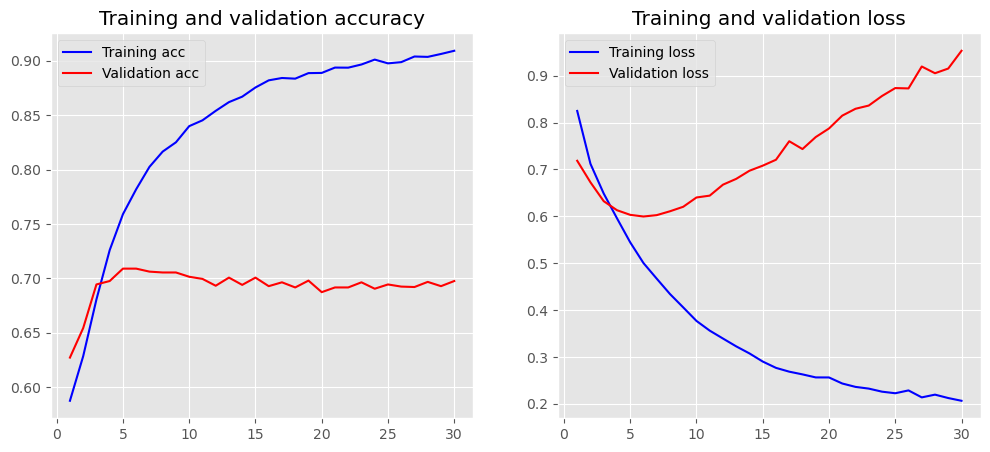

In [121]:
plot_history(history)